In [50]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import tensorflow as tf
import os
import cv2
import imghdr

data_dir = '/content/drive/MyDrive/ClassificationUsingCNN/Images'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Adjusted for simplified folder structure
for image_class in os.listdir(data_dir):
    class_folder = os.path.join(data_dir, image_class)
    for image in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)


Found 445 files belonging to 2 classes.
Using 312 files for training.


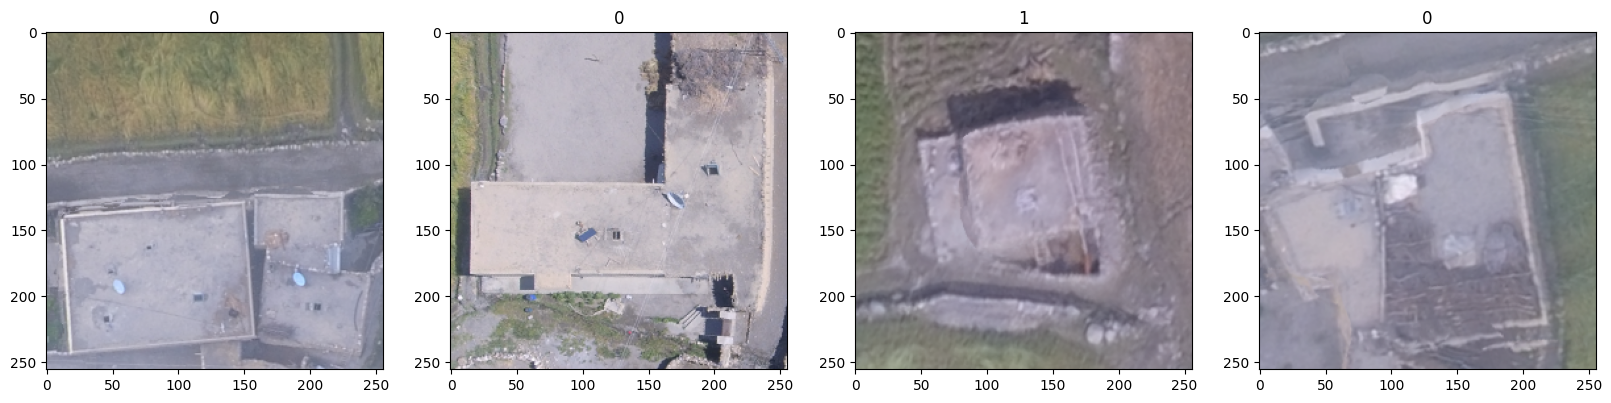

In [54]:
import numpy as np
from matplotlib import pyplot as plt

# Update the path to the dataset
data = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.3, subset="training", seed=123)

data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

data = data.map(lambda x, y: (x / 255, y))

train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

test_size

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)


In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model = Sequential()

model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

Epoch 1/20
7/7 [==============================] - 8s 262ms/step - loss: 1.3604 - accuracy: 0.5402 - val_loss: 0.6891 - val_accuracy: 0.5469
Epoch 2/20
7/7 [==============================] - 2s 243ms/step - loss: 0.6942 - accuracy: 0.5223 - val_loss: 0.6883 - val_accuracy: 0.5156
Epoch 3/20
7/7 [==============================] - 2s 241ms/step - loss: 0.7044 - accuracy: 0.5536 - val_loss: 0.6596 - val_accuracy: 0.6250
Epoch 4/20
7/7 [==============================] - 2s 243ms/step - loss: 0.6772 - accuracy: 0.6027 - val_loss: 0.6599 - val_accuracy: 0.8281
Epoch 5/20
7/7 [==============================] - 4s 504ms/step - loss: 0.6591 - accuracy: 0.6384 - val_loss: 0.6360 - val_accuracy: 0.6719
Epoch 6/20
7/7 [==============================] - 2s 245ms/step - loss: 0.6170 - accuracy: 0.7545 - val_loss: 0.5978 - val_accuracy: 0.8594
Epoch 7/20
7/7 [==============================] - 3s 275ms/step - loss: 0.5583 - accuracy: 0.7946 - val_loss: 0.5658 - val_accuracy: 0.7812
Epoch 8/20
7/7 [====

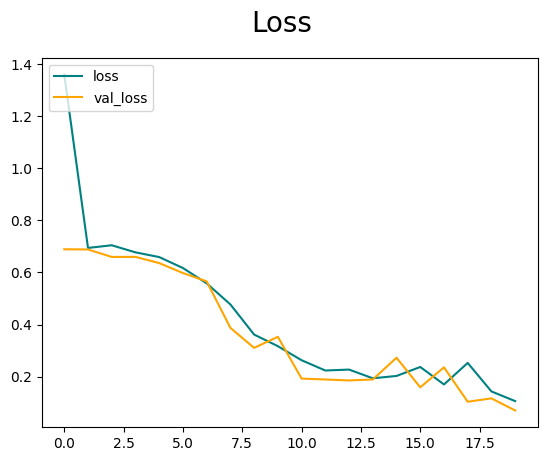

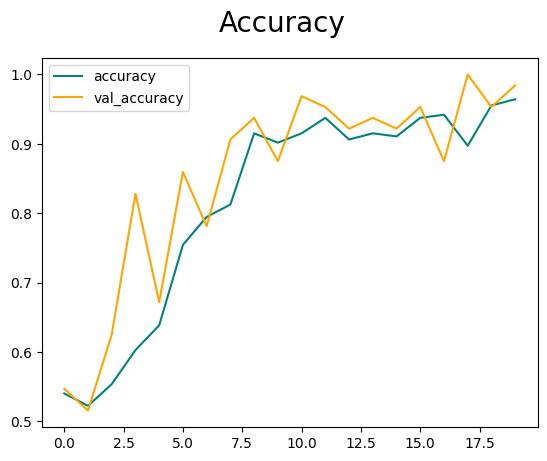

In [56]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


1/1 [==============================] - 0s 109ms/step


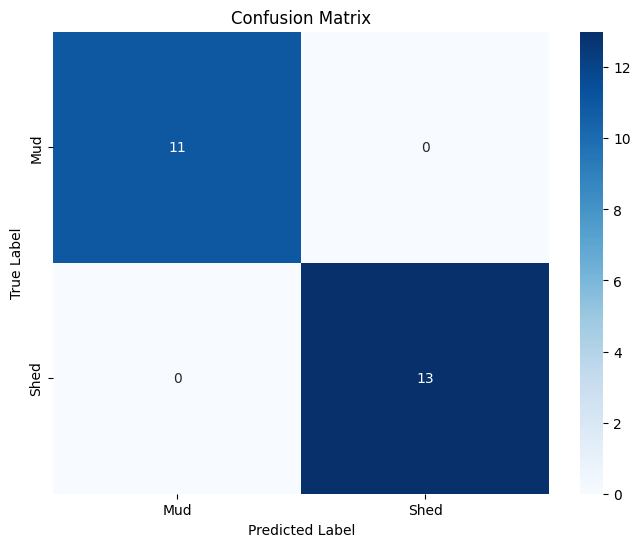

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    y_true.extend(y)
    y_pred.extend(yhat.flatten())

# Convert to binary labels (0 or 1)
y_true = np.array(y_true)
y_pred = (np.array(y_pred) > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Mud', 'Shed'], yticklabels=['Mud', 'Shed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


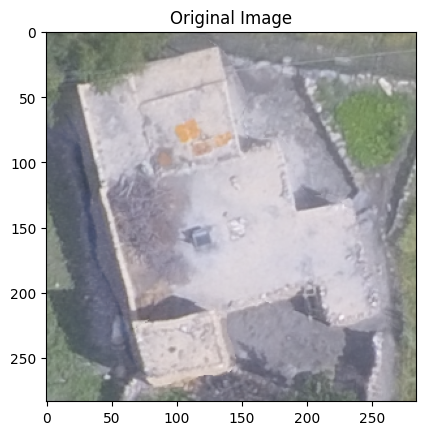

1/1 [==============================] - 0s 63ms/step
Predicted class is Mud


In [69]:
# Load the image
img = cv2.imread('/content/drive/MyDrive/ClassificationUsingCNN/Images/Mud/NP_64.png')

# Convert BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the original image
plt.imshow(img_rgb)
plt.title('Original Image')
plt.show()

# Resize the image
resize = tf.image.resize(img_rgb, (256, 256))

# Make prediction
yhat = model.predict(np.expand_dims(resize / 255, 0))

# Print the predicted class
if yhat > 0.5:
    print(f'Predicted class is Shed')
else:
    print(f'Predicted class is Mud')


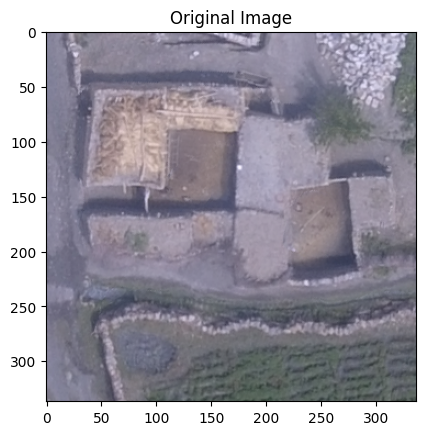

1/1 [==============================] - 0s 92ms/step
Predicted class is Shed


In [70]:
# Load the image
img = cv2.imread('/content/drive/MyDrive/ClassificationUsingCNN/Images/Shed/52.png')

# Convert BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the original image
plt.imshow(img_rgb)
plt.title('Original Image')
plt.show()

# Resize the image
resize = tf.image.resize(img_rgb, (256, 256))

# Make prediction
yhat = model.predict(np.expand_dims(resize / 255, 0))

# Print the predicted class
if yhat > 0.5:
    print(f'Predicted class is Shed')
else:
    print(f'Predicted class is Mud')
